## Simple classifier using a KNN algorithm: results analysis with different metrics

На предыдущем этапе можно пронаблюдать, что различные оптимизации признаков не уменьшают ошибку классификатора.
Поэтому для анализа результатов с различными метриками возьмем baseline с CountVectorizer или TF-IDF Vectorizer.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pymystem3 import Mystem
from nltk.corpus import stopwords
from string import punctuation

import nltk
import re


/home/andrey/PycharmProjects/sentences_analysis/venv/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### 1. Load data

In [3]:
# open excel-file
data = pd.read_excel('data/KNN (1-3,5).xlsx')  

### 2. Preprocessing

In [4]:
nltk.download("stopwords")
russian_stopwords = stopwords.words("russian")
mystem = Mystem()
# data = pd.DataFrame(data[1:], columns=data[0])

[nltk_data] Downloading package stopwords to /home/andrey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Функция для предобработки предложений. Что она делает:
+ Лемматизация слов
+ Отбрасывание стоп-слов (частицы, союзы, местоимения)
+ Удаление знаков пунктуации


In [5]:
def preprocess_sentence(sentence):
    tokens = mystem.lemmatize(sentence.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    tokenized_sentence = " ".join(tokens)
    return tokenized_sentence   

Функция для предобротки меток (эмоций) из разметки:

+ Разбиение на отдельные классы
+ Нормализация классов (сведение более мягких эмоций к более сильным)
+ Проверка, что указана корректная эмоция (одна из эмоций по теории Келлермана-Плутчика)

In [6]:
emotions_table = {
    'восторг': 'восторг',
		'радость': 'восторг',
		'безмятежность': 'восторг',
    'восхищение': 'восхищение',
		'доверие': 'восхищение',
		'принятие': 'восхищение',
    'ужас': 'ужас',
		'страх': 'ужас',
		'тревога': 'ужас',
    'изумление': 'изумление',
		'удивление': 'изумление',
		'возбуждение': 'изумление',
    'горе': 'горе',
		'грусть': 'горе',
		'печаль': 'горе',
    'отвращение': 'отвращение',
		'неудовольствие': 'отвращение',
		'скука': 'отвращение',
    'гнев': 'гнев',
		'злость': 'гнев',
		'досада': 'гнев',
    'настороженность': 'настороженность',
		'ожидание': 'настороженность',
		'интерес': 'настороженность',
}

def normalize_emotion(emotion):
    emotion = emotion.lower()
    result = emotions_table.get(emotion)
    assert result is not None, f"Emotion '{emotion}' is not correct one."
    return result

Непосредственно предобработка данных из файла с разметкой:

In [7]:
processed_sentences = list(map(preprocess_sentence, data['Предложение']))
temp = pd.DataFrame(columns=['Предложение', 'Эмоция'])

for i, (emotion, sentence) in enumerate(zip(data['Эмоция'], processed_sentences)):
    if any(delim in emotion for delim in (' ', ',', '.', '\n')):
        emotions = [normalize_emotion(e) for e in re.split('[ ,.\n]', emotion.strip()) if e != '']
        # for e in emotions:
        #     temp = temp.append({'Предложение': sentence, 'Эмоция': e}, ignore_index=True)
        temp = temp.append({'Предложение': sentence, 'Эмоция': emotions[0]}, ignore_index=True)
    else:
        temp = temp.append({'Предложение': sentence, 'Эмоция': normalize_emotion(emotion)}, ignore_index=True)

processed_data = temp

### 3. Modelling with CountVectorizer and TF-IDF Vectorizer

In [8]:
from typing import List, Iterable, Dict, Tuple

import collections
import itertools
import scipy
import time

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk.stem.snowball import RussianStemmer
stemmer = RussianStemmer()

vectorizer_tfidf = TfidfVectorizer()
vectorizer_tfidf.fit(processed_data['Предложение'])
tfidf_vec_matrix = vectorizer_tfidf.transform(processed_data['Предложение'])

vectorizer_count = CountVectorizer()
vectorizer_count.fit(processed_data['Предложение'])
count_vec_matrix = vectorizer_count.transform(processed_data['Предложение'])



### 3.1 Обучение классификатора 
Строим модели с разнами разбиениями датасета и разными k для KNN.

In [9]:
DEFAULT_COLORS = ['red', 'green', 'orange', 'purple', 'blue', 'gray', 'pink']
DEFAULT_SPLITS = [0.20, 0.30, 0.40, 0.50]

def get_colors(n):
  colors = DEFAULT_COLORS[:n]
  if n > len(DEFAULT_COLORS):
    import matplotlib, random
    all_colours = matplotlib.colors.get_named_colors_mapping()
    colors.extend(random.choices(all_colours, k=n-len(DEFAULT_COLORS)))
  return colors

def _knn_analysis(X, y, splits, k_interval) -> Tuple[List[List[float]], List[List[float]], Dict[str, int]]:
  error_over_splits_train = []
  error_over_splits_test = []
  best_result = {'split': 0, 'k': 0, 'error': 1}
  for split in splits:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)
    #---------------------
    # here could be scaler
    #---------------------
    # Comparing Error Rate with the K Value
    # (calculating error for K values in k_range)
    err_one_split_test = []
    err_one_split_train = []
    
    for i in k_interval:
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)
        
        y_train_predict = knn.predict(X_train)
        y_test_predict = knn.predict(X_test)
        
        err_train_tmp = np.mean(y_train != y_train_predict)
        err_test_tmp = np.mean(y_test != y_test_predict)
        
        err_one_split_test.append(err_test_tmp)
        err_one_split_train.append(err_train_tmp)
        
        # check the best result
        if err_test_tmp < best_result['error']:
            best_result['split'] = split
            best_result['k'] = i
            best_result['error'] = err_test_tmp
    error_over_splits_train.append(err_one_split_train)
    error_over_splits_test.append(err_one_split_test)
  return error_over_splits_train, error_over_splits_test, best_result

### 3.2 Визуализация результатов

In [10]:
def visualize_knn_analysis(X, y, splits=None, min_k=1, max_k=40):
  if not splits:
    splits = DEFAULT_SPLITS
  k_range = range(min_k, max_k+1)
  
  # Training and Predictions
  errors_over_splits_train, errors_over_splits_test, best_res = _knn_analysis(X, y, splits, k_range)
          
  # Plot results
  plt.figure(num=1, figsize=(12, 6))
  for test_size, errors_on_split, color in zip(splits, errors_over_splits_train, get_colors(len(splits))):
    label_name = str(int(test_size * 100)) + '%/'+ str(int((1 - test_size) * 100)) + '%'
    plt.plot(k_range, errors_on_split, color=color, marker='o', markerfacecolor='blue', markersize=2, label=label_name)

  plt.title('Error Rate K Value')
  plt.xlabel('K Value')
  plt.ylabel('Mean Train Error')
  plt.legend(loc='best')
  
  plt.figure(num=2, figsize=(12, 6))
  for test_size, errors_on_split, color in zip(splits, errors_over_splits_test, get_colors(len(splits))):
    label_name = str(int(test_size * 100)) + '%/'+ str(int((1 - test_size) * 100)) + '%'
    plt.plot(k_range, errors_on_split, color=color, marker='o', markerfacecolor='blue', markersize=2, label=label_name)
  plt.title('Error Rate K Value')
  plt.xlabel('K Value')
  plt.ylabel('Mean Test Error')
  plt.legend(loc='best')
  
  print("Best set:")
  print("Split: " + str(int((1 - best_res['split']) * 100)) + '%/' + str(int(best_res['split'] * 100)) + '%')
  print("K: " + str(best_res['k']))
  print("Error value: " + str(best_res['error']))

### 3.3 Оптимизация пространства признаков

In [11]:
def feature_optimize(X:scipy.sparse.csr_matrix, vectorizer, comparator, *, stemming=False, debug=False, **kwargs) -> scipy.sparse.csr_matrix:
  df = pd.DataFrame(X.toarray(), columns=vectorizer.vocabulary_)
  if debug:
    print(f'Columns before: {len(df.columns)}')

  # getting similar columns
  start = time.time()
  similar_col_groups = collections.defaultdict(set)
  if stemming:
    words_and_stems = {w: stemmer.stem(w) for w in df.columns}
    df = df.groupby(level=0, axis=1).sum()
  words = list(df.columns)
  for i, (w1, w2) in enumerate(filter(lambda word_pair: comparator(*word_pair, **kwargs), 
                                      itertools.combinations(words, 2)), 1):
    similar_col_groups[w1].add(w2)
    similar_col_groups[w2].add(w1)
    if debug:
      if i % 1000 == 0:
        print(f"{i} entries are matched by comparator")
  if debug:
    print('PROCESSING TIME:', time.time() - start)
    print(f'Got similar_col_groups (len: {len(similar_col_groups)})')
  
  _merge_intersecting_groups(similar_col_groups)
  if debug:
    print('Groups after merging:', len(similar_col_groups))

  df = join_columns(similar_col_groups.items(), df, debug)
  if debug:
    print(f'Columns after: {len(df.columns)}')
  return scipy.sparse.csr_matrix(df.values)

def _merge_intersecting_groups(similar_col_groups):
  def merge_subkeys_into_group(main_key, group, subkeys=None):
    if subkeys is None:
      subkeys = set(group)
    else:
      group.update(subkeys)
    for key in subkeys:
      if key in similar_col_groups:
        new_keys = similar_col_groups[key] - group - {key, main_key}
        if len(new_keys) > 0:
          merge_subkeys_into_group(main_key, group, new_keys)
        del similar_col_groups[key]
  for key in tuple(similar_col_groups.keys()):
    if key in similar_col_groups:
      group = similar_col_groups[key]
      merge_subkeys_into_group(key, group)
      
def join_columns(column_groups: Iterable[Tuple[str, Iterable[str]]], df: pd.DataFrame, debug) -> pd.DataFrame:
  if debug:
    print('DF in "join_columns":\n', df)
  for key, group in column_groups:
    for subkey in group:
      if subkey in df.columns:
        try:
          df[key] += df[subkey]
        except Exception as e:
          rendered_cols = ", ".join(f"'{col_name}" for col_name in df.columns)
          rendered_group = ", ".join(f"'{k}'" for k in group)
          print(f"key: '{key}'; subkey '{subkey}' [cols: {rendered_cols}] [group: {rendered_group}]")
          print(f"df[key]: {df[key]}; df[subkey]: {df[subkey]}")
          exit('ERROR')
        del df[subkey]
      elif debug:
        rendered_cols = ", ".join(f"'{col_name}" for col_name in df.columns)
        rendered_group = ", ".join(f"'{k}'" for k in group)
        print(f"key: '{key}'; subkey '{subkey}' do not exist in DF [cols: {rendered_cols}] [group: {rendered_group}]")
  return df


## 4. Analysis: CountVectorizer and TF-IDF Vectorizer comparison

#### 4.1 **Baseline**

In [13]:
X_count = count_vec_matrix
X_tfidf = tfidf_vec_matrix
y = processed_data['Эмоция'].to_numpy()

CountVectorizer:
Best set:
Split: 80%/20%
K: 1
Error value: 0.6666666666666666


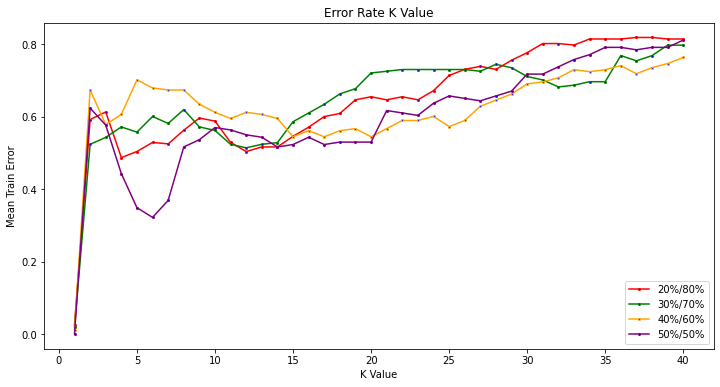

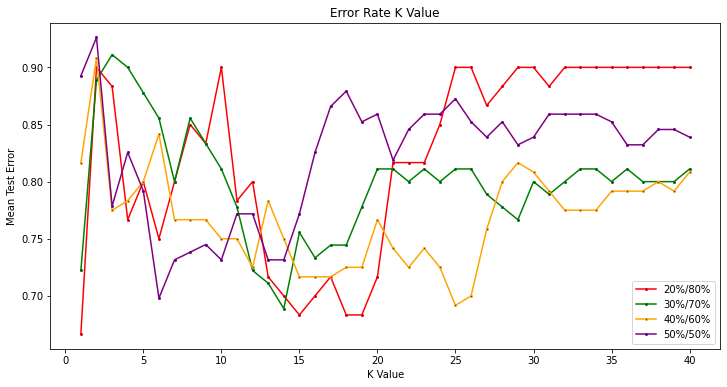

In [14]:
print("CountVectorizer:")
visualize_knn_analysis(X_count, y)

TF-IDF Vectorizer:
Best set:
Split: 80%/20%
K: 24
Error value: 0.5833333333333334


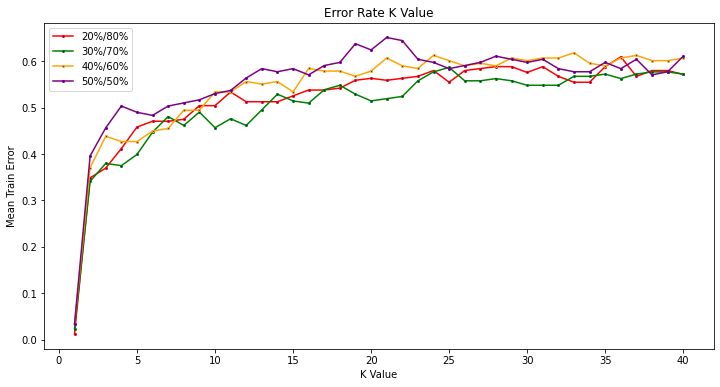

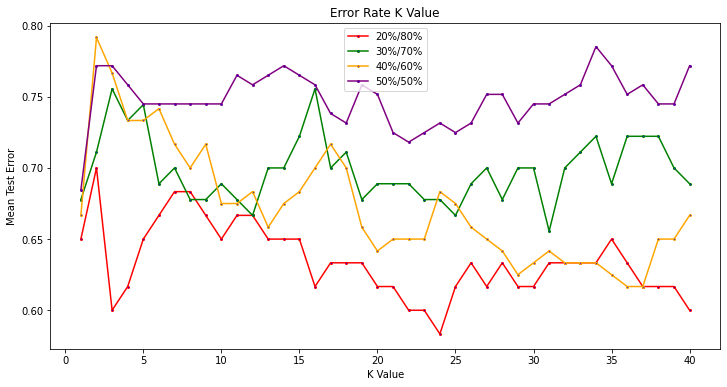

In [15]:
print("TF-IDF Vectorizer:")
visualize_knn_analysis(X_tfidf, y)

## 5. Results analysis


Наименьшая ошибка получается при использованиии TF-IDF Vectorizer, исполььзуем его для анализа
 результатов на различных метриках.
 
Best set:

Split: 80%/20%

K: 24

Error value: 0.5833333333333334

In [16]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, log_loss, classification_report
from sklearn.preprocessing import MultiLabelBinarizer

In [17]:
# classes = ['гнев', 'отвращение', 'горе', 'изумление', 'ужас', 'восхищение', 'восторг', 'настроженность']
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, stratify=y)
knn = KNeighborsClassifier(n_neighbors=24)
knn.fit(X_train, y_train)
knn_probs = knn.predict_proba(X_test)
classes = knn.classes_
y_pred = knn.predict(X_test)

mlb = MultiLabelBinarizer(classes=classes)
y_test_bin = mlb.fit_transform([[x] for x in y_test])

### Классические бинарные метрики, баланс классов

                 precision    recall  f1-score   support

        восторг       0.00      0.00      0.00         8
     восхищение       0.00      0.00      0.00         6
           гнев       0.24      0.43      0.31        14
           горе       0.00      0.00      0.00        12
      изумление       0.54      0.58      0.56        12
настороженность       1.00      0.17      0.29         6
     отвращение       0.43      0.33      0.38         9
           ужас       0.41      0.70      0.52        23

       accuracy                           0.37        90
      macro avg       0.33      0.28      0.26        90
   weighted avg       0.32      0.37      0.31        90



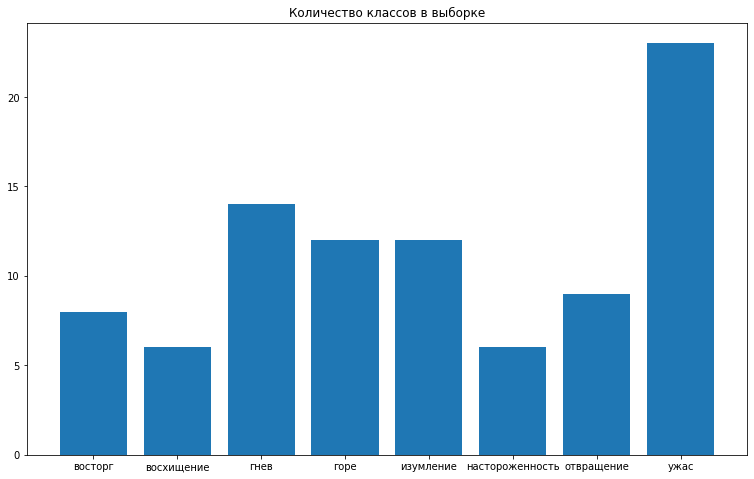

In [23]:
report_table = classification_report(y_test, knn.predict(X_test), target_names=classes)
print(report_table)

report_dict = classification_report(y_test, y_pred, target_names=classes, output_dict=True)

fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Количество классов в выборке")
support = [report_dict[label]['support'] for label in classes]
ax.bar(classes, support)
plt.show()


### Метрики качества многоклассовой классификации: микро- и макро-усреднение

In [19]:
micro = f1_score(y_test, y_pred, average = 'micro')
macro = f1_score(y_test, y_pred, average = 'macro')
print("Micro: ", micro)
print("Micro: ", macro)

Micro:  0.36666666666666664
Micro:  0.2555669532080822


### Метрики качества: AUC-ROC, AUC-PR

In [ ]:
roc_auc = roc_auc_score(y_test_bin, knn_probs)
aps = average_precision_score(y_test_bin, knn_probs)
print("AUC-ROC: ", roc_auc)
print("AUC-PR: ", aps)


### Метрики качества: logloss

In [ ]:

ll = log_loss(y_test_bin, knn_probs)
print("log-loss: ", ll)